In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc

import requests
from urllib.parse import urlencode

### Загрузка файлов

In [2]:
link_groups = 'groups.csv'
link_groups_add = 'group_add.csv'
link_active_studs = 'active_studs.csv'
link_checks = 'checks.csv'

In [3]:
groups = pd.read_csv(link_groups, sep=';')
group_add = pd.read_csv(link_groups_add, sep=',')
active_studs = pd.read_csv(link_active_studs)
checks = pd.read_csv(link_checks, sep=';')

### groups
файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
# Проверим на наличие пропусков в дф
groups.isnull().sum()

id     0
grp    0
dtype: int64

### groups_add
дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [6]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
# Проверим на наличие пропусков в дф
group_add.isnull().sum()

id     0
grp    0
dtype: int64

Поскольку у нас есть файл, который нам прислали дополнительно к нашим группам, объединим эти файлы сразу в один датафрейм `groubs_ab`

In [8]:
groups_ab = pd.concat([groups, group_add], ignore_index=True)
groups_ab.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


### active_studs
файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента 

In [9]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
# Проверим на наличие пропусков в дф
active_studs.isnull().sum()

student_id    0
dtype: int64

### checks
файл с информацией об оплатах пользователей в дни проведения эксперимента

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [12]:
# Проверим на наличие пропусков в дф
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [13]:
# Посмотрим на поближе на чеки в нашем датафрейме
np.sort(checks.rev.unique())

array([ 199.    ,  290.    ,  398.    ,  489.    ,  580.    ,  590.    ,
        597.    ,  630.    ,  690.    ,  796.    ,  840.    ,  870.    ,
        880.    ,  990.    , 1039.    , 1050.    , 1140.    , 1160.    ,
       1180.    , 1339.    , 1388.    , 1530.    , 1729.    , 1830.    ,
       1900.    , 1900.0001, 1968.    , 1980.    , 2099.    , 2190.    ,
       2220.    , 2820.    , 2890.    , 2900.    , 2910.    , 3040.    ,
       3260.    , 3660.    , 4650.    ])

Анализ данных демонстрирует наличие ограниченного спектра основных услуг, каждая из которых ассоциируется с определенной стоимостью. Единственное значение, выделяющееся в наборе, – `1900.0001`. С наибольшей вероятностью данное значение является результатом некорректного округления. Поэтому произведем замену всех вхождений числа `1900.0001` на `1900`, чтобы исключить возможность ошибки.

In [14]:
checks = checks.replace(1900.0001, 1900.)
np.sort(checks.rev.unique())

array([ 199.,  290.,  398.,  489.,  580.,  590.,  597.,  630.,  690.,
        796.,  840.,  870.,  880.,  990., 1039., 1050., 1140., 1160.,
       1180., 1339., 1388., 1530., 1729., 1830., 1900., 1968., 1980.,
       2099., 2190., 2220., 2820., 2890., 2900., 2910., 3040., 3260.,
       3660., 4650.])

## На какие метрики стоит ориентироваться в ходе анализа и почему?

Поскольку в наших данных есть только `id` пользователей и доход от сделки, но отстутствуют  то мы можем найти только 3 основные метрики исходя из этих данных:
1. <span style="color:Tomato">**CR**</span> - Conversion Rate
2. <span style="color:Tomato">**ARPU**</span> - Average Revenue Per User
3. <span style="color:Tomato">**ARPPU**</span> - Average Revenue Per Paying User

### <span style="color:Tomato">1. Пойдем по порядку и для начала найдем `CR`:</span>

#### <span style="color:DarkGreen">1. В первую очередь важно учитывать следующее:</span>

Поскольку эксперимент должен планироваться на основе мощности и MDE теста, а значит количество пользователей должно быть подсчитано, то при учете, что наш эксперимент закончился именно наши активные пользователи могут дать ответ на вопрос о статначимых различиях, а значит для дальнейших рассчетов нам необходимы только те пользователи, которые посетили платформу в дни A/B теста. 

Проверим все `id` в датафрейме `groups_ab`. Если в таблице `active_studs` собраны все `id` посетившие платформу в дни проведения эксперимента, то они должны быть в датафрейме `groups_ab`.

In [15]:
active_studs['student_id'].isin(groups_ab['id']).all()

True

Оставим в датафрейме только актинвых пользователей:

In [16]:
active = groups_ab['id'].isin(active_studs['student_id'])
ab_test_sample = groups_ab[active]

Соберем первый датафрейм для рассчета конверсии:

In [17]:
coversion_df = ab_test_sample.copy()
coversion_df['convert'] = ab_test_sample['id'].isin(checks['student_id']).astype(int)
coversion_df.head()

,id,grp,convert
1,1627,A,1
10,2085,B,0
12,2215,B,0
43,3391,A,0
45,3401,B,0


In [18]:
# Рассчитаем коэффициент конверсии(CR) для групп А и В
CR_a = round(coversion_df.query('grp == "A" & convert == 1').convert.count()
             / coversion_df.query('grp == "A"').convert.count()
             * 100, 2)
CR_b = round(coversion_df.query('grp == "B" & convert == 1').convert.count()
             / coversion_df.query('grp == "B"').convert.count()
             * 100, 2)

In [19]:
print(f'''CR в группе А = {CR_a}%.
CR в группе B = {CR_b}%''')

CR в группе А = 5.07%.
CR в группе B = 4.62%


#### <span style="color:DarkGreen">2. Проверим статзначимость различия конверсии в наших группах:</span>

Для начала сформулируем гипотезы:

- `H0`: Между конверсией в группе A и конверсией в группе B нет разницы.
- `H1`: Между конверсией в группе A и конверсией в группе B есть разница.

Конверсия - номинативная переменная, а значит для проверки различий между группами я буду использовать критерий Хи-квадрат Пирсона. И если у нас изменится число конверсий для каждого пользователя в разных группах, то соответственно изменится и `Conversion Rate`(**CR**).

Для этого сделаем таблицу сопряженности по нашим группам:

In [20]:
crosstab_cr = pd.crosstab(coversion_df.grp, coversion_df.convert)
crosstab_cr

convert,0,1
grp,,
A,1460,78
B,6489,314


Применяем критерий Пирсона для нашей таблицы:

In [21]:
stat, p, df, expcted = sc.chi2_contingency(crosstab_cr)

In [22]:
round(p, 2)

0.49

<span style="color:Tomato">**Вывод:**</span>

p-value в результате нашего теста равен <span style="color:Tomato">**0.49**</span>, а значит мы не можем отклонить нулевую гипотезу о том, что частоты конверсии в двух группах не различаются. 

Из этого мы делаем вывод, что `Conversion Rate` тоже никак не изменился, поскольку различия в конверсиях в группах не статзначимо

### <span style="color:Tomato">2. Следующим шагом рассмотрю метрику `ARPU`:</span>

#### <span style="color:DarkGreen">1. Для этого потребуется выделить отдельный датафрейм с данными об активных пользователях и оценить доход, генерируемый каждым из пользователей: </span>

In [23]:
arpu_sample = (
                ab_test_sample.merge(checks, left_on='id', right_on='student_id', how='left')
                               .drop(columns='student_id')
               )

In [24]:
# Все пропущенные значения заполним нулями
arpu_sample['rev'] = arpu_sample.rev.fillna(0)

In [25]:
# Поделим пользователей на группы
arpu_a_group = arpu_sample.query('grp == "A"')
arpu_b_group = arpu_sample.query('grp == "B"')

#### <span style="color:DarkGreen">2. Посмотрим на наши распределения поближе. Поскольку у нас разное количество людей в группах, лучше посмотреть на распределение на разных графиках, чтобы понимать общую картину распределения дохода для каждой группы:</span>

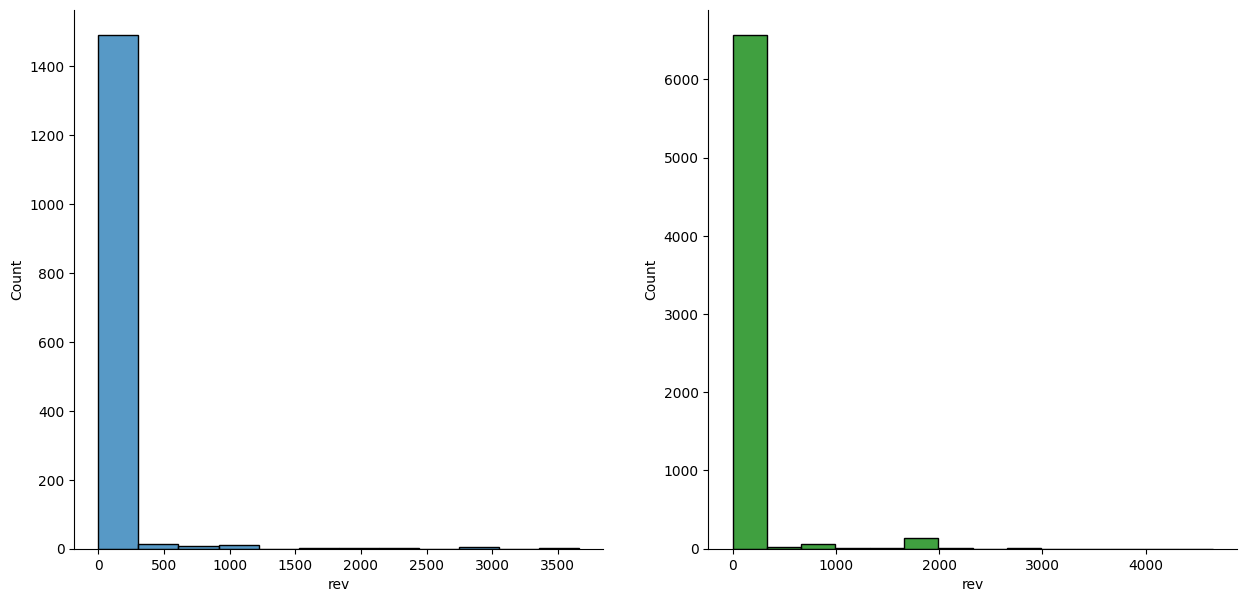

In [26]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.histplot(arpu_a_group.rev)
plt.subplot(1, 2, 2)
sns.histplot(arpu_b_group.rev, color='green')
sns.despine()

#### <span style="color:DarkGreen">3. Подытожим результаты:</span>

Поскольку нам необходимо сравнивать средние значения для метрики `ARPU`(это у нас и будет статистикой теста) в двух группах, то нам предстоит выбирать из двух тестов:

- <span style="color:Tomato">**t-критерий Стьюдента**</span>
- <span style="color:Tomato">**Bootstrap**</span>

тест Манна-Уитни сравнивает ранги распределений из общей "корзины" признаков, поэтому при использовании теста Манна-Уитни мы не получим никакого результата о наших средних значениях. 

В данных распределениях большая часть наблюдений сплотилась в левой части графика, а остальная часть является выбросами, поэтому результат работы <span style="color:Tomato">**t-критерия Стьюдента**</span> может быть некорректной, даже не смотря на достаточное количество наблюдений в группах. 

Поэтому для сравнения средних значений я буду применять <span style="color:Tomato">**Bootstrap**</span> средних

<span style="color:DarkGreen">**4. Сформулируем гипотезы:**</span>

- `H0`: ARPU в группе A и в группе B не различаются.
- `H1`: ARPU в группе A и в группе B различаются.

In [27]:
print(f'''ARPU в группе А = {round(arpu_a_group.rev.mean(), 2)}.
ARPU в группе B = {round(arpu_b_group.rev.mean(), 2)}''')

ARPU в группе А = 47.35.
ARPU в группе B = 58.06


In [28]:
# Функция для статистики в bootstrap
def mean_difference(data1, data2):
    return np.mean(data2) - np.mean(data1)

In [29]:
# Считаем бутстрап средних для ARPU
arpu_result = sc.bootstrap((arpu_a_group.rev, arpu_b_group.rev),
                           statistic=mean_difference,
                           n_resamples=10000,
                           method='basic')

In [30]:
# Рассчет разницы средних и доверительный интервал запишем в отдельные переменные
mean_diff = arpu_result.bootstrap_distribution
conf_interval = (arpu_result.confidence_interval[0], arpu_result.confidence_interval[1])

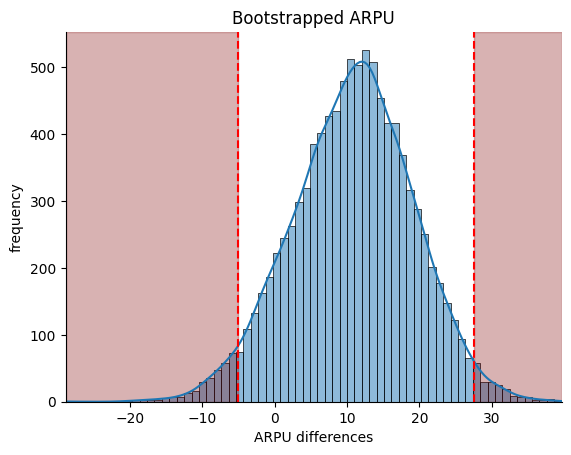

In [31]:
# Построим график распределения разницы средних между нашими группами
ax = sns.histplot(mean_diff, kde=True)
ax.axvline(conf_interval[0], linestyle='--', color='red') # Граница 0.05 для распределения
ax.axvline(conf_interval[1], linestyle='--', color='red') # Граница 0.95 для распределения
ax.axvspan(mean_diff.min(), conf_interval[0], color='Maroon', alpha=0.3) # Закрасим границу 0.05 для распределения
ax.axvspan(mean_diff.max(), conf_interval[1], color='Maroon', alpha=0.3) # Закрасим границу 0.95 для распределения
ax.set_xlim(mean_diff.min(), mean_diff.max()) # Установим ограничения по оси х для графика
ax.set_xlabel('ARPU differences')
ax.set_ylabel('frequency')
ax.set_title(f'Bootstrapped ARPU')
sns.despine()

<span style="color:Tomato">**Вывод:**</span>

Исходя из проведенного бутстрапа средних значений для разницы между двумя группами и полученного 95% доверительного интервала, можно сделать следующие выводы:

<span style="color:Tomato">**95%**</span> доверительный интервал для разницы средних содержит значение <span style="color:Tomato">**0**</span>, а значит Мы не можем отклонить нулевую гипотезу о том, что ARPU в группе A и в группе B не различаются.

### <span style="color:Tomato">3. Следующим шагом рассмотрю метрику `ARPPU`:</span>

#### <span style="color:DarkGreen">1. Для этого потребуется выделить отдельный датафрейм с данными об активных пользователях и оценить доход, генерируемый каждым из платящих пользователей: </span>

In [32]:
arppu_sample = (
                ab_test_sample.merge(checks, left_on='id', right_on='student_id')
                               .drop(columns='student_id')
               )

In [33]:
arppu_sample.head()

,id,grp,rev
0,1627,A,990.0
1,100300,B,990.0
2,108270,B,290.0
3,264473,B,1900.0
4,274352,B,690.0


In [34]:
# Поделим пользователей на группы
arppu_a_group = arppu_sample.query('grp =="A"')
arppu_b_group = arppu_sample.query('grp =="B"')

#### <span style="color:DarkGreen">2. Посмотрим на наши распределения поближе. Поскольку у нас разное количество людей в группах, лучше посмотреть на распределение на разных графиках, чтобы понимать общую картину распределения дохода для каждой группы:</span>

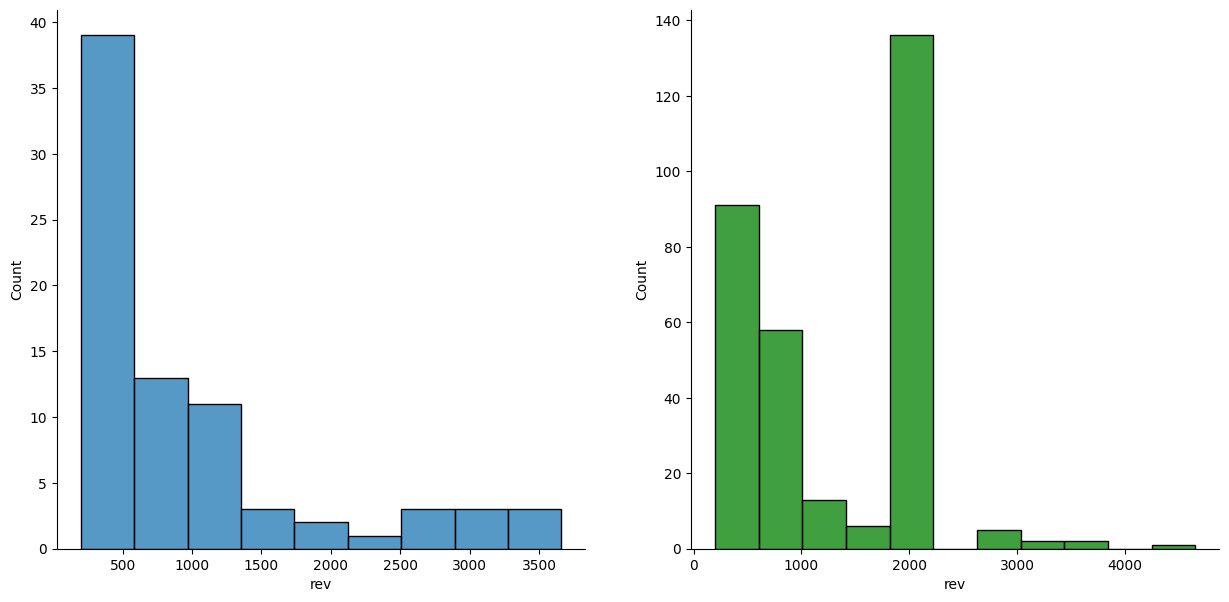

In [35]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.histplot(arppu_a_group.rev)
plt.subplot(1, 2, 2)
sns.histplot(arppu_b_group.rev, color='green')
sns.despine()

#### <span style="color:DarkGreen">3. Подытожим результаты:</span>

Поскольку нам необходимо сравнивать средние значения для метрики `ARPPU`(это у нас и будет статистикой теста) в двух группах, то нам предстоит выбирать из двух тестов:

- <span style="color:Tomato">**t-критерий Стьюдента**</span>
- <span style="color:Tomato">**Bootstrap**</span>

тест Манна-Уитни уже обсуждался выше, он нам не подходит.

Данное распределение на графиках выгляжит уже не столь перекошенным и без явных выбросов, поэтому наиболее робастным для определения среднего из этих двух тестов является <span style="color:Tomato">**t-критерий Стьюдента**</span>, но у него есть несколько важных требований к данным, а именно:

<span style="color:Tomato">**1.**</span> Независимость наблюдений(мы можем проверить только пересечение id в группах,а остальное зависит от системы сплитования). Поэтому первым делом проверим нет ли пересечений id между группами:

In [36]:
arppu_a_group['id'].isin(arppu_b_group['id']).all()

False

Пересечений `id` в группах нет, а значит переходим к следующему пункту

<span style="color:Tomato">**2.**</span> Гомогенность дисперсий, т.е. дисперсии в двух выборках приблизительно одинаковы. Данный пункт проверим критерием Левена:

In [37]:
sc.levene(arppu_a_group.rev, arppu_b_group.rev, center='mean')

LeveneResult(statistic=0.35109193873977856, pvalue=0.5538390465371114)

p-value равен 0,55. Это означает, что мы не смогли отвергнуть нулевую гипотезу о том, что в наших группах дисперсии не различаются. То есть дисперсии в группах примерно равны, а значит движемся дальше.

<span style="color:Tomato">**3.**</span> Нормальность распределения исследуемого признака в генеральной совокупности(чего мы узнать не можем), либо нормальное распределение средних, что связано со стандартной ошибкой в знаменателе t-критерия(и этот пункт мы узнать не можем). Поэтому довольствуемся тем, что у нас не сильно маленькое количество наблюдений в выборках, то есть не меньше 30, из-за чего нам не приходится проверять нормальность распределения признака.

<span style="color:Tomato">**4.**</span> Отсутствие выбросов. Данный пункт мы можем проверить с помощью боксплота или следующей функции, которая смотрит на 1 и 3 квартиль, прибавляет к ним 1.5 межквартильного размаха и если за ними находятся отдаленные от границ значения, то значит в наших данных присутствуют выбросы:

In [38]:
def outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    upper_array = data.where(data>=upper).count()
    lower_array = data.where(data<=lower).count()

    return print(f'''Выбросы: нижние {lower_array} и верхние {upper_array}''')

outliers(arppu_a_group.rev), outliers(arppu_b_group.rev)

Выбросы: нижние 0 и верхние 9
Выбросы: нижние 0 и верхние 1


(None, None)

<Axes: xlabel='grp', ylabel='rev'>

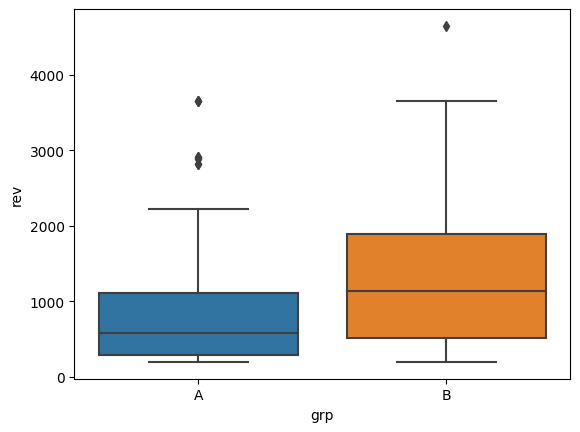

In [39]:
sns.boxplot(data=arppu_sample, x='grp', y='rev')

<span style="color:Tomato">**Вывод:**</span>

Таким образом мы видим, что в группе А у нас присутствует 9 выбросов, а значит мы не можем применять t-test для наших групп. В таком случае мы можем применить только <span style="color:Tomato">**bootstrap**</span> средних.

<span style="color:DarkGreen">**4. Сформулируем гипотезы:**</span>

- `H0`: ARPPU в группе A и в группе B не различаются.
- `H1`: ARPPU в группе A и в группе B различаются.

In [40]:
# Считаем бутстрап средних для ARPPU
result = sc.bootstrap((arppu_a_group.rev, arppu_b_group.rev),
                      statistic=mean_difference,
                      n_resamples=10000)

In [41]:
# Рассчет разницы средних и доверительный интервал запишем в отдельные переменные
mean_diff = result.bootstrap_distribution
conf_interval = (result.confidence_interval[0], result.confidence_interval[1])

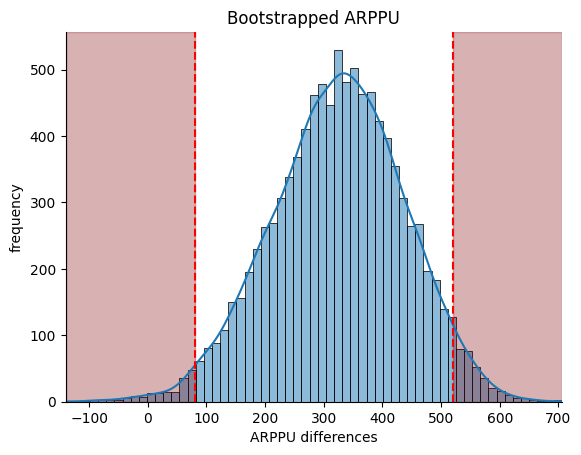

In [42]:
# Построим график распределения разницы средних между нашими группами
ax = sns.histplot(mean_diff, kde=True)
ax.axvline(conf_interval[0], linestyle='--', color='red') # Граница 0.05 для распределения
ax.axvline(conf_interval[1], linestyle='--', color='red') # Граница 0.95 для распределения
ax.axvspan(mean_diff.min(), conf_interval[0], color='Maroon', alpha=0.3) # Закрасим границу 0.05 для распределения
ax.axvspan(mean_diff.max(), conf_interval[1], color='Maroon', alpha=0.3) # Закрасим границу 0.95 для распределения
ax.set_xlim(mean_diff.min(), mean_diff.max()) # Установим ограничения для графика
ax.set_xlabel('ARPPU differences')
ax.set_ylabel('frequency')
ax.set_title(f'Bootstrapped ARPPU')
sns.despine()

<span style="color:Tomato">**Вывод:**</span>

Исходя из проведенного бутстрапа средних значений для разницы между двумя группами и полученного 95% доверительного интервала, можно сделать следующие выводы:

<span style="color:Tomato">**95%**</span> доверительный интервал для разницы средних не содержит значение <span style="color:Tomato">**0**</span>, а значит мы можем отклонить нулевую гипотезу о том, что ARPPU в группе A и в группе B не различаются. Таким образом мы делаем вывод, что `ARPPU` в группах статзначимо различается.

<span style="color:DarkGreen">**5. Далее я хочу проверить распределение revenue более подробно. Рассмотрим какие покупки совершались чаще всего по группам:**</span>


In [43]:
(
    arppu_sample.groupby(['grp','rev'])
                .agg({'id':'count'})
                .pivot_table(columns='grp', index='rev', values='id')
                .sort_values(['B', 'A'], ascending=False)
                .head(10)
)

grp,A,B
rev,,
1900.0,NaN,128.0
290.0,25.0,45.0
199.0,5.0,27.0
840.0,3.0,21.0
990.0,5.0,17.0
690.0,4.0,13.0
1140.0,2.0,9.0
590.0,5.0,6.0
398.0,1.0,6.0


Из представленных выше графиков распределений становится очевидным, что в общем виде наши распределения схожи. Однако следует отметить, что в группе B особенно выделяется одно значение - 1900. Это значение отсутствует в контрольной группе, что позволяет предположить, что новая механика оплаты услуг на сайте вероятно связана с этим конкретным числом.

Обнаружение данного значения позволяет нам увидеть, что форма нашего распределения изменилась, и среднее значение сместилось в направлении этой новой популярной услуги. Сейчас я бы хотел более детально рассмотреть данное распределение и, используя метод бутстрапа, проанализировать, каким образом изменились процентили в наших распределениях.

In [44]:
# Создаем словарь для записи результатов бутстрапа и лист с основными процентилями
dct = dict()
lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [45]:
# С помощью цикла будем пробегать по основным процентилям и бутстрапом детектировать разницу между процентилями
for i, quant in enumerate(lst):
    
    def quantile_difference(data1, data2):
        return pd.Series(data2).quantile(quant) - pd.Series(data1).quantile(quant)
    
    result = sc.bootstrap((arppu_a_group.rev, arppu_b_group.rev),
                          statistic=quantile_difference,
                          n_resamples=10000,
                          method='percentile')
    
    quant_diff = result.bootstrap_distribution
    conf_interval = (result.confidence_interval[0], result.confidence_interval[1])
    
    dct[f'{quant*100}%'] = [quant_diff, conf_interval] # Записываем в словарь результат для каждого процентиля

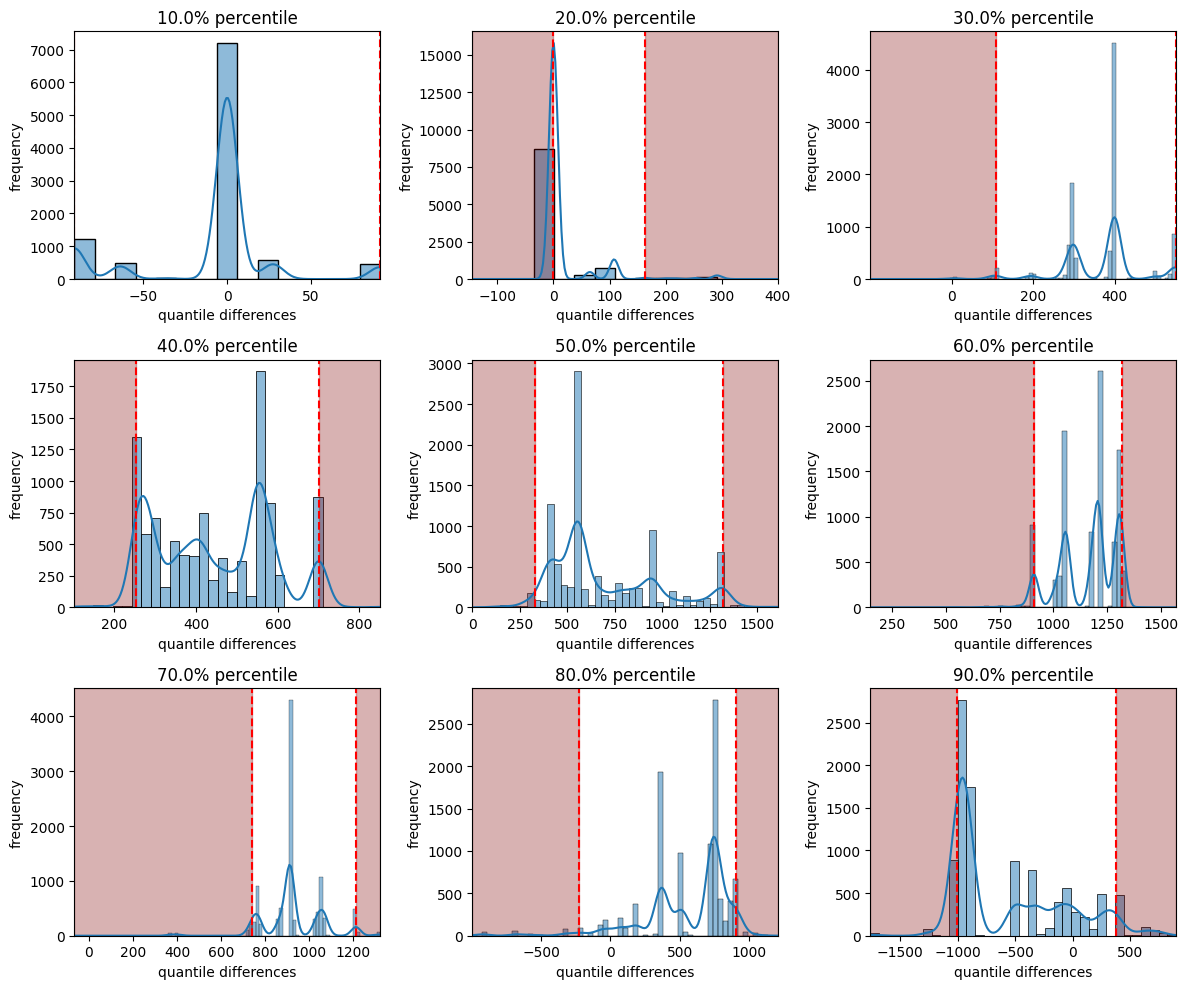

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten() # преобразует двумерный массив 3х3 в одномерный массив из 9 элементов, для цикла.

# Построение графиков циклом
for i, (label, values) in enumerate(dct.items()):
    quant_diff, conf_interval = values
    
    ax = sns.histplot(quant_diff, ax=axes[i], kde=True)
    ax.axvline(conf_interval[0], linestyle='--', color='red')
    ax.axvline(conf_interval[1], linestyle='--', color='red')
    ax.axvspan(quant_diff.min(), conf_interval[0], color='Maroon', alpha=0.3)
    ax.axvspan(quant_diff.max(), conf_interval[1], color='Maroon', alpha=0.3)
    ax.set_xlim(quant_diff.min(), quant_diff.max())
    ax.set_xlabel('quantile differences')
    ax.set_ylabel('frequency')
    ax.set_title(f'{label} percentile')

plt.tight_layout() # Для избежания перекрытия графиков

<span style="color:Tomato">**Вывод:**</span>

Анализируя предоставленные распределения, мы можем утверждать о существенных статистических различиях в процентилях 30, 40, 50, 60 и 70. Эти различия указывают на положительную динамику изменения дохода в группе B по сравнению с группой A. Это в свою очередь указывает на увеличение дохода от наших платящих клиентов. Несмотря на наличие в группе B отдельных значительных показателей дохода, отсутствующих в группе A, следует признать, что главным фактором роста является значение 1900. С большой вероятностью именно оно оказывает существенное влияние на структуру распределения.

Важно отметить, что для более точных выводов и основательного анализа необходимо учесть характер A/B-теста, его параметры и изменения, которые были внесены. Это позволит установить более четкие основания для интерпретации полученных результатов и сделать более обоснованные выводы.

### <span style="color:SteelBlue">Заключение:</span>

1. После анализа различий в `CR` между нашими группами я не обнаружил статистически значимых отличий. Следовательно, можно сделать вывод, что новая механика оплаты услуг на сайте не оказала влияния на изменения в `CR`.
2. После анализа различий в `ARPU` между нашими группами я не обнаружил статистически значимых отличий. Следовательно, можно сделать вывод, что новая механика оплаты услуг на сайте не оказала влияния на изменения в `ARPU`.
3. Однако в анализе различий `ARPPU` я обнаружил статистически значимый эффект. Это подтверждает, что механика оплаты услуг на сайте действительно повлияла на данную метрику. Такая метрика как `ARPPU` играет важную роль в `unit-экономике` продукта и если бы мы смогли изменить конверсию в покупку, то за счет изменения метрики `ARPPU` мы бы получили статзначимые результаты и в метрике `ARPU`. 
4. Также я дополнительно провел исследование по процентилям распределений, и получил статзначимые результаты в 30, 40, 50, 60 и 70 процентилях. 
5. Считаю, что новую механику оплаты услуг <span style="color:SteelBlue">**стоит запускать на всех пользователей!**</span>